In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below
df = pd.get_dummies(df, columns=["language", "canton", "typology"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 87)
y_train.shape = (1756,)
X_test.shape = (440, 87)
y_test.shape = (440,)


In [4]:
svr = SVR(kernel="rbf", gamma="scale")
print(svr.fit(X_train, y_train))
svr_test_pred = svr.predict(X_test)
print("With default params:")
print("SVR MAE = {:.3f}".format(mean_absolute_error(y_test, svr_test_pred)))
print("SVR R^2 = {:.3f}".format(svr.score(X_test, y_test)))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
With default params:
SVR MAE = 0.264
SVR R^2 = 0.214


In [5]:
parameters = {
    "C": np.logspace(-5, 5, 31),
    "gamma": np.logspace(-10, 0, 11)
}
gcv = GridSearchCV(svr, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12, verbose=True)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv.best_params_))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Fitting 5 folds for each of 341 candidates, totalling 1705 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    9.7s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   22.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   39.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1705 out of 1705 | elapsed: 19.6min finished


Grid search / cross-validation:
Best params = {'C': 4.641588833612772, 'gamma': 1e-09}
Best MAE = 0.175


In [6]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned SVR MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned SVR R^2 = {:.3f}".format(r2_score(y_test, svr_test_pred)))

On test data:
Tuned SVR MAE = 0.170
Tuned SVR R^2 = 0.214


In [7]:
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.set_style('whitegrid')
    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmax()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

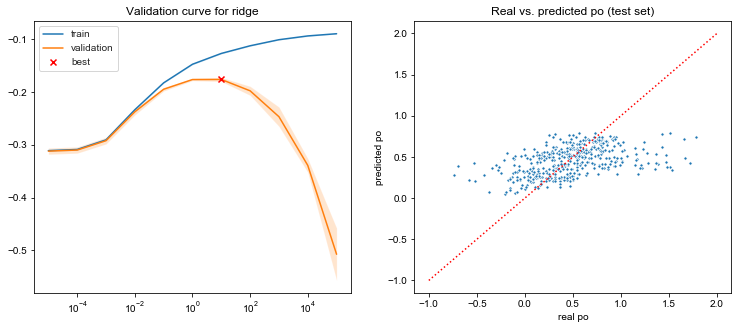

In [10]:
svr2 = SVR(kernel="rbf", gamma=gcv.best_params_["gamma"])
param_range = np.logspace(-5, 5, 11)
train_scores, valid_scores = validation_curve(svr2, X_train, y_train, param_name="C",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge", param_range, train_scores, valid_scores, ax1)

sns.scatterplot(y_test, svr_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()